In [34]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import holidays

In [35]:
df = pd.read_parquet("all_tlc_data_cleaned.parquet")
df.rename({'datetime':'timestamp'}, axis=1,inplace=True)

In [36]:
df_wth = pd.read_csv("meteostat_weather.csv")

In [37]:
df_wth.rename({'time':'timestamp'}, axis=1,inplace=True)
df_wth

,timestamp,temp,dwpt,rhum,prcp,pres,coco
0,2021-01-01 00:00:00,4.0,-4.0,56.0,0.0,1026.3,4.0
1,2021-01-01 01:00:00,3.0,-4.0,60.0,0.0,1027.7,4.0
2,2021-01-01 02:00:00,3.0,-4.0,60.0,0.0,1028.1,4.0
3,2021-01-01 03:00:00,2.0,-3.9,65.0,0.0,1029.2,3.0
4,2021-01-01 04:00:00,2.0,-5.0,60.0,0.0,1029.9,3.0
...,...,...,...,...,...,...,...
30212,2024-06-12 20:00:00,25.6,10.6,39.0,0.0,1015.0,3.0
30213,2024-06-12 21:00:00,24.6,11.2,43.0,0.0,1014.9,3.0
30214,2024-06-12 22:00:00,23.1,14.4,58.0,0.0,1015.0,3.0
30215,2024-06-12 23:00:00,21.5,15.6,69.0,0.0,1015.1,3.0


In [38]:
df_wth['timestamp'] = df_wth['timestamp'].astype('datetime64[us]')
df_wth['timestamp'] = pd.to_datetime(df_wth['timestamp'])
df_wth['coco'] = df_wth['coco'].astype('category')


In [39]:
df_wth.dtypes

timestamp    datetime64[us]
temp                float64
dwpt                float64
rhum                float64
prcp                float64
pres                float64
coco               category
dtype: object

In [40]:
df.sort_values(by=['timestamp'])

,timestamp,location,passenger_count
0,2021-01-01,3,132
162,2021-01-01,171,84
163,2021-01-01,172,35
164,2021-01-01,173,202
165,2021-01-01,174,350
...,...,...,...
7319637,2024-04-01,90,1
7319638,2024-04-01,107,1
7319639,2024-04-01,163,6
7319640,2024-04-01,225,1


In [41]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [42]:
df_wth.sort_values(by=['timestamp'])

,timestamp,temp,dwpt,rhum,prcp,pres,coco
0,2021-01-01 00:00:00,4.0,-4.0,56.0,0.0,1026.3,4.0
1,2021-01-01 01:00:00,3.0,-4.0,60.0,0.0,1027.7,4.0
2,2021-01-01 02:00:00,3.0,-4.0,60.0,0.0,1028.1,4.0
3,2021-01-01 03:00:00,2.0,-3.9,65.0,0.0,1029.2,3.0
4,2021-01-01 04:00:00,2.0,-5.0,60.0,0.0,1029.9,3.0
...,...,...,...,...,...,...,...
30212,2024-06-12 20:00:00,25.6,10.6,39.0,0.0,1015.0,3.0
30213,2024-06-12 21:00:00,24.6,11.2,43.0,0.0,1014.9,3.0
30214,2024-06-12 22:00:00,23.1,14.4,58.0,0.0,1015.0,3.0
30215,2024-06-12 23:00:00,21.5,15.6,69.0,0.0,1015.1,3.0


In [43]:
df.dtypes

timestamp          datetime64[us]
location                    int64
passenger_count             int64
dtype: object

In [44]:
df = df.join(df_wth.set_index('timestamp'), on='timestamp', how='left')

In [45]:
df_wth = df_wth.set_index("timestamp")

In [46]:
df = df.rename({'location': 'item_id', 'passenger_count':'target'}, axis=1)

In [47]:
df

,timestamp,item_id,target,temp,dwpt,rhum,prcp,pres,coco
0,2021-01-01,3,132,4.0,-4.0,56.0,0.0,1026.3,4.0
1,2021-01-01,4,234,4.0,-4.0,56.0,0.0,1026.3,4.0
2,2021-01-01,5,19,4.0,-4.0,56.0,0.0,1026.3,4.0
3,2021-01-01,6,37,4.0,-4.0,56.0,0.0,1026.3,4.0
4,2021-01-01,7,493,4.0,-4.0,56.0,0.0,1026.3,4.0
...,...,...,...,...,...,...,...,...,...
7319638,2024-04-01,107,1,13.3,-0.7,38.0,0.0,1014.4,3.0
7319639,2024-04-01,163,6,13.3,-0.7,38.0,0.0,1014.4,3.0
7319640,2024-04-01,225,1,13.3,-0.7,38.0,0.0,1014.4,3.0
7319641,2024-04-01,226,1,13.3,-0.7,38.0,0.0,1014.4,3.0


In [48]:
static_features_df = pd.read_csv("taxi_zone_lookup.csv")
static_features_df.rename({'LocationID': 'item_id'}, axis=1, inplace=True)
static_features_df

,item_id,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [49]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=static_features_df,
)



In [50]:
def add_weekends_holidays(data: TimeSeriesDataFrame):
    WEEKEND_INDICES = [5, 6]
    timestamps = data.index.get_level_values("timestamp")
    data["weekend"] = timestamps.weekday.isin(WEEKEND_INDICES).astype(float)
    data.head()

    # Get US holidays
    country_holidays = holidays.country_holidays(
        country="US",  
        years=range(timestamps.min().year, timestamps.max().year + 1),
    )
    # Get dummies
    holidays_df = pd.get_dummies(pd.Series(country_holidays)).astype(float)
    # Reindex by hour
    holidays_df = holidays_df.reindex(timestamps.date).fillna(0)
    # Add holidays col, 1 if any of the holidays, 0 otherwise
    data['holiday'] = holidays_df.max(axis=1).values

In [51]:
add_weekends_holidays(data)

In [52]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)


In [53]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="initial_model",
    target="target",
    eval_metric="MASE",
    freq='h',
    known_covariates_names=['temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco', 'weekend',
       'holiday']
)

predictor.fit(
    train_data,
    presets="high_quality"
)

Beginning AutoGluon training...
AutoGluon will save models to 'initial_model'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       5.79 GB / 15.90 GB (36.4%)
Disk Space Avail:   2030.22 GB / 2794.50 GB (72.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['temp',
                            'dwpt',
                            'rhum',
                            'prcp',
                            'pres',
                            'coco',
                            'weekend',
                            'holiday'],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'r

In [ ]:
predictor.leaderboard(test_data)


data with frequency 'None' has been resampled to frequency 'h'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Naive,-2.642323,-2.354159,1.230396,3.777086,6.556254,1
1,SeasonalNaive,-3.313393,-1.339581,4.608782,1.122494,6.749906,2


In [ ]:
prediction_length

2160

In [ ]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
add_weekends_holidays(known_covariates)
known_covariates = known_covariates.join(df_wth, on='timestamp', how='left')

c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [ ]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)
predictions.head()

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


mean         0.1         0.2         0.3  \
item_id timestamp                                                        
3       2024-01-01 23:00:00  192.0  148.366343  163.344881  174.145461   
        2024-01-02 00:00:00  130.0   86.366343  101.344881  112.145461   
        2024-01-02 01:00:00  193.0  149.366343  164.344881  175.145461   
        2024-01-02 02:00:00  178.0  134.366343  149.344881  160.145461   
        2024-01-02 03:00:00  130.0   86.366343  101.344881  112.145461   

                                    0.4    0.5         0.6         0.7  \
item_id timestamp                                                        
3       2024-01-01 23:00:00  183.374159  192.0  200.625841  209.854539   
        2024-01-02 00:00:00  121.374159  130.0  138.625841  147.854539   
        2024-01-02 01:00:00  184.374159  193.0  201.625841  210.854539   
        2024-01-02 02:00:00  169.374159  178.0  186.625841  195.854539   
        2024-01-02 03:00:00  121.374159  130.0  138.625841  147.854539   

                                    0.8         0.9  
item_id timestamp                                    
3       2024-01-01 23:00:00  220.655119  235.633657  
        2024-01-02 00:00:00  158.655119  173.633657  
        2024-01-02 01:00:00  221.655119  236.633657  
        2024-01-02 02:00:00  206.655119  221.633657  
        2024-01-02 03:00:00  158.655119  173.633657

In [ ]:
predictions

mean          0.1          0.2  \
item_id timestamp                                                    
68      2024-04-01 00:00:00   455.494992   218.456338   299.175448   
        2024-04-01 01:00:00   239.322142   -89.965112    22.934244   
        2024-04-01 02:00:00   126.015817  -274.764377  -137.255597   
        2024-04-01 03:00:00   113.847571  -344.665944  -187.858417   
        2024-04-01 04:00:00   146.112611  -366.695418  -191.070363   
...                                  ...          ...          ...   
        2024-05-30 19:00:00  1417.345547 -7941.960446 -4749.726144   
        2024-05-30 20:00:00  1294.644436 -7998.653981 -4833.703187   
        2024-05-30 21:00:00  1237.576245 -8037.305078 -4872.219234   
        2024-05-30 22:00:00  1215.728712 -8002.132126 -4856.764871   
        2024-05-30 23:00:00  1113.479037 -8006.500420 -4894.136248   

                                     0.3         0.4          0.5  \
item_id timestamp                                                   
68      2024-04-01 00:00:00   357.428500  408.329361   455.494992   
        2024-04-01 01:00:00   104.403404  174.167425   239.322142   
        2024-04-01 02:00:00   -38.437560   46.847385   126.015817   
        2024-04-01 03:00:00   -73.677547   23.232320   113.847571   
        2024-04-01 04:00:00   -63.842340   44.649110   146.112611   
...                                  ...         ...          ...   
        2024-05-30 19:00:00 -2447.489747 -485.294385  1417.345547   
        2024-05-30 20:00:00 -2550.960440 -594.868756  1294.644436   
        2024-05-30 21:00:00 -2581.037843 -631.728586  1237.576245   
        2024-05-30 22:00:00 -2580.901980 -630.483473  1215.728712   
        2024-05-30 23:00:00 -2634.387490 -712.887238  1113.479037   

                                     0.6          0.7          0.8  \
item_id timestamp                                                    
68      2024-04-01 00:00:00   502.841621   553.022152   611.611610   
        2024-04-01 01:00:00   304.223695   374.235437   456.173728   
        2024-04-01 02:00:00   205.687834   290.422810   389.753263   
        2024-04-01 03:00:00   205.284431   303.156457   416.831724   
        2024-04-01 04:00:00   247.833387   356.859138   483.647952   
...                                  ...          ...          ...   
        2024-05-30 19:00:00  3225.515256  5243.964729  7618.958937   
        2024-05-30 20:00:00  3097.192398  5106.027356  7436.070438   
        2024-05-30 21:00:00  3039.445263  5052.280937  7365.402855   
        2024-05-30 22:00:00  3007.959485  5004.937945  7316.771987   
        2024-05-30 23:00:00  2904.823007  4853.008729  7137.617785   

                                      0.9  
item_id timestamp                          
68      2024-04-01 00:00:00    693.848658  
        2024-04-01 01:00:00    569.752728  
        2024-04-01 02:00:00    527.320300  
        2024-04-01 03:00:00    574.396205  
        2024-04-01 04:00:00    660.636528  
...                                   ...  
        2024-05-30 19:00:00  10857.239423  
        2024-05-30 20:00:00  10693.757392  
        2024-05-30 21:00:00  10630.462925  
        2024-05-30 22:00:00  10547.155825  
        2024-05-30 23:00:00  10313.128244  

[1440 rows x 10 columns]

data with frequency 'None' has been resampled to frequency 'h'.


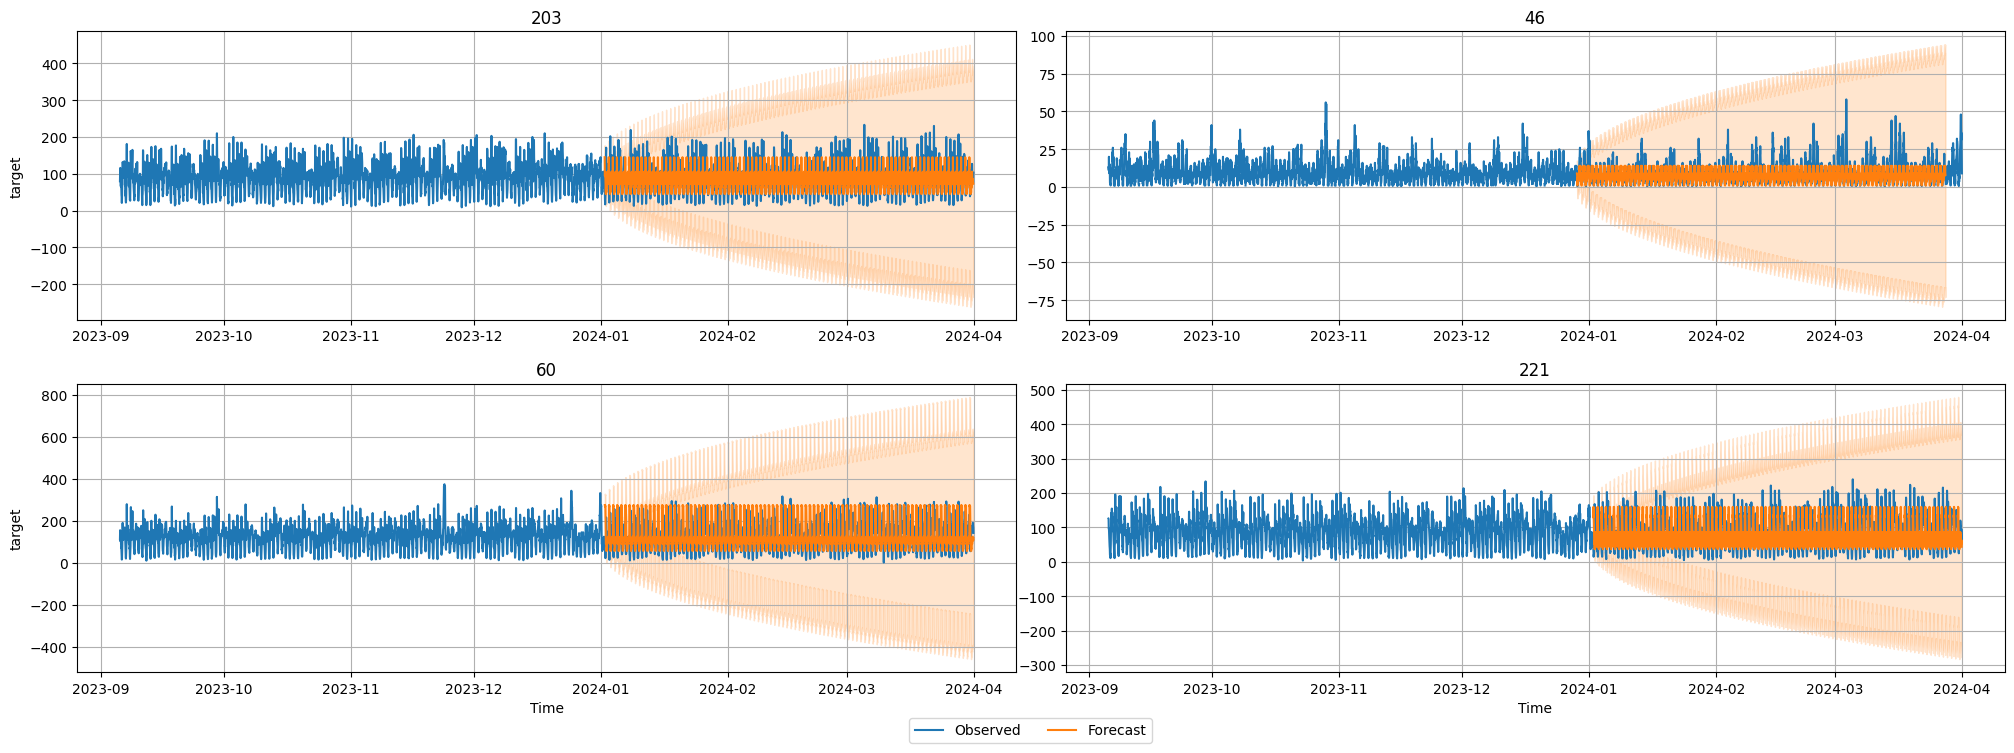

In [ ]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=5000, max_num_item_ids=4)